In [58]:
from gpjax.gps import Prior
from gpjax.kernel import RBF
from gpjax.likelihoods import Gaussian
from gpjax.sampling import random_variable, sample
from gpjax.mlls import marginal_ll
from gpjax.transforms import transform, untransform, SoftplusTransformation
import jax.numpy as jnp
import jax.random as jr
from jax import value_and_grad
from jax.experimental import optimizers
import matplotlib.pyplot as plt
key = jr.PRNGKey(123)

## Synthetic datasets

With necessary libraries and modules imported we can simulate some data. We'll sample our inputs $x$ according to $x_1, \ldots , x_{50} \sim \mathcal{U}(-3., 3)$ and corresponding outputs will be,

$$y_i = \sin(4x_i) + \cos(2 x_i) + \epsilon_i,$$
    
such that $\epsilon_i \sim \mathcal{N}(0, 0.1)$.

In [2]:
N = 50
noise = 0.2

x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(N,)).sort().reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(key, shape=signal.shape) * noise
xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

To better understand the data that we have simulated, we can plot both the underlying function along with the observations that we have assumed to be perturbed by some isotropic Gaussian noise.

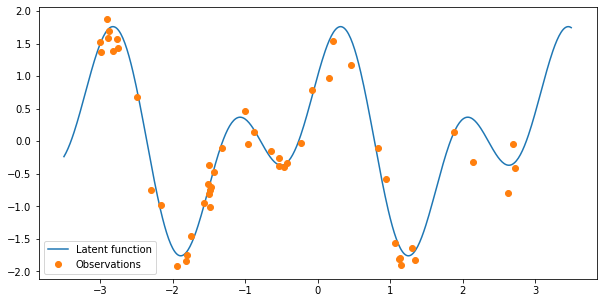

In [64]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(xtest, ytest, label="Latent function", color="tab:blue")
ax.plot(x, y, "o", label="Observations", color="tab:orange")
ax.legend(loc="best")

## Define GP prior

We can now set about defining our model. A zero-mean Gaussian process places a prior over $f$ such that $p(f) \sim \mathcal{N}(0, K_{xx})$ where $K_{xx}$ is the Gram matrix that is generated by a user-specified kernel function $k$ such that $[K_{xx}]_{i, j} = k(x_i, x_j)$. The choice of kernel function is an important choice as, among other things, it governs the smoothness of the outputs that our Gaussian process model can generate. For now, we'll use a squared exponential kernel which takes the form   

$$k(x, x') = \sigma^2 \exp\left(-\frac{\lVert x-x' \rVert_2^2}{2 \ell^2}\right).$$


As we can see, the squared exponential kernel has two parameters; a lengthscale $\ell$ that controls horizontal displacement, and a variance term $\sigma$ that controls vertical displacement. We'll initialise both these terms at 1.

In [117]:
p = Prior(kernel=RBF())

## Computing the posterior

The posterior distribution is proportional to the prior multiplied by a likelihood function. For this example we'll assume that the likelihood function is a Gaussian distribution. Using this, we can easily compute the posterior.

In [118]:
lik = Gaussian()
posterior = p * lik

### Stating parameters

To store our model's hyperparameters, we suggest using a dictionary. In this example, our kernel is parameterised by a lengthscale and variance parameters. Further, our likelihood functions controls the amount of observation noise; the final parameter that we must optimise. These three quantities should therefore be defined as

In [119]:
params = {
    'lengthscale': jnp.array([1.]),
    'variance': jnp.array([1.]),
    'obs_noise': jnp.array([1.])
}

## Optimisation

To learn the optimal set of hyperparameters, we'll optimise the marginal log-likelihood of the posterior with respect to the hyperparameters. To realise this function, one can run the following.

In [120]:
mll = marginal_ll(posterior, negative=True)

In [121]:
value_and_grad(mll)(params, x, y)

(DeviceArray(70.98359482, dtype=float64),
 {'lengthscale': DeviceArray([5.72563898], dtype=float64),
  'obs_noise': DeviceArray([7.40040318], dtype=float64),
  'variance': DeviceArray([-0.80603009], dtype=float64)})

Note that most optimisers (including here) minimise a given function. Truly, we wish to maximise the marginal log-likelihood, so we instead realise the negative marginal log-likelihood so that the minimisation is equivalent to maximising the marginal log-likelihood.

### Parameter transformation

The three parameters we defined earlier are all strictly positive. To ensure more stable optimisation, it is strongly advised to transform the parameters onto an unconstrained space first. Through the `transform` function and a given bijective transformation function this can be achieved as follows

In [122]:
params = transform(params, SoftplusTransformation)

### Defining an optimiser

We can now define an optimiser using and of the optimiser's supplied in Jax's experimental module. For this example we'll use the adam optimiser with a step-size of $0.01$.

In [123]:
opt_init, opt_update, get_params = optimizers.adam(step_size=0.01)
opt_state = opt_init(params)

A training routine now can be defined where the `value_and_grad` function in Jax is used to compute the gradient and value of the marginal log-likelihood with respect to our current parameter set.

In [133]:
def step(i, opt_state):
    p = get_params(opt_state)
    v, g = value_and_grad(mll)(p, x, y)
    return opt_update(i, g, opt_state), v

Optimisation can now be conducted for 500 iterations.

In [125]:
nits = 500
mlls = []

for i in range(nits):
    opt_state, mll_estimate = step(i, opt_state)
    mlls.append(-mll_estimate)

## Optimisation performance

We stored a running estimate of the marginal log-likelihood during optimisation so that we can retrospectively assess convergence.

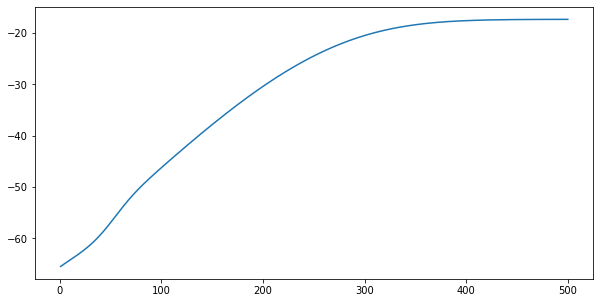

In [134]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(1, nits+1), mlls)

## Learned parameters

The exact value of our learned parameters can often be useful in answering certain questions about the underlying process. To find these values, we should untransfom them so that they are redefined on the original constrained space.

In [137]:
final_params = untransform(get_params(opt_state), SoftplusTransformation)
final_params

{'lengthscale': DeviceArray([0.42745334], dtype=float64),
 'obs_noise': DeviceArray([0.03770831], dtype=float64),
 'variance': DeviceArray([1.23617853], dtype=float64)}

## Prediction

### Direct prediction

We a posterior distribution and a set of optimised hyperparameter values, we are now in a position to query our GP's predictive posterior distribution at a set of test points. To do this, we can either compute the process' expectation and variance directly using the following `mean` and `variance` functions.

In [139]:
from gpjax.predict import mean, variance

predictive_mean = mean(posterior, final_params, xtest, x, y)
predictive_variance = variance(posterior, final_params, xtest, x, y)

### Realising the random variable

The predictive posterior is itself a Gaussian random variable, and we can compute this quantity using the `random_variable` function. This returns a TensorFlow distribution that is defined in TensorFlow Probability's Jax substrate.

In [140]:
predictive_rv = random_variable(posterior, final_params, xtest, x, y)

Using this random variable, we can directly compute the predictive mean and variance. Note, this yields identical values to the `mean` and `variance` commands from earlier.

In [143]:
mu = posterior_rv.mean()
sigma = posterior_rv.variance()
one_stddev = 1.96*jnp.sqrt(sigma)

With the predictive mean and variance acquired, we can now visualise how well our GP does at explaining the original data.

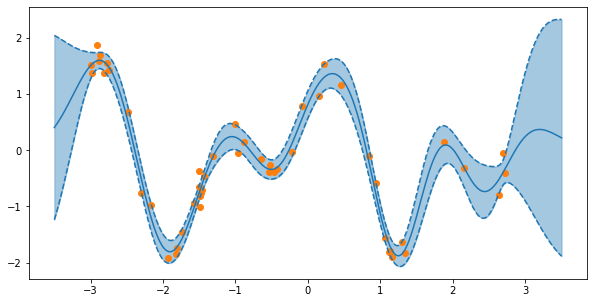

In [148]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y, 'o', color='tab:orange')
ax.plot(xtest, mu, color='tab:blue')
ax.fill_between(xtest.ravel(), mu.ravel() - one_stddev, mu.ravel() + one_stddev, alpha=0.4, color='tab:blue')
ax.plot(xtest, mu.ravel() - one_stddev, linestyle='--', color='tab:blue')
ax.plot(xtest, mu.ravel() + one_stddev, linestyle='--', color='tab:blue')

## Sampling from a GP

Through the `sample` function we are able to draw functions for a given GP at a certain set of points. To demonstrate this, we'll draw samples from the prior and the posterior to observe the difference in our prior beliefs vs the posterior.

Note, we are able to sample from either the process itself or the random variable, as shown in the below chunk.

Text(0.5, 1.0, 'Posterior samples')

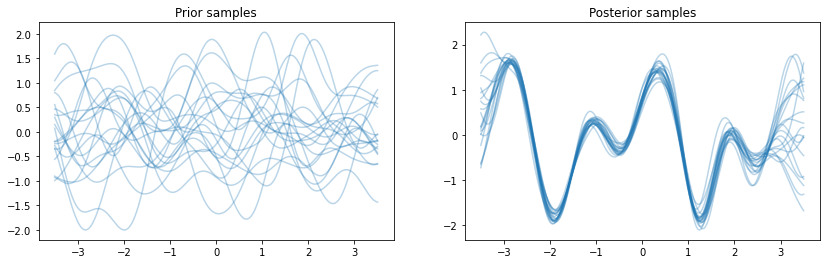

In [153]:
prior_samples = sample(key, p, params, xtest, n_samples=20)
posterior_samples = sample(key, posterior_rv, n_samples=20)

fig, ax = plt.subplots(figsize = (14, 4), ncols=2)
ax[0].plot(xtest, prior_samples.T, color='tab:blue', alpha=0.3)
ax[0].set_title('Prior samples')

ax[1].plot(xtest, posterior_samples.T, color='tab:blue', alpha=0.3)
ax[1].set_title('Posterior samples')

## Random variable querying

Up to this point, it may seem an additional complication to realise the random variable instead of just computing the desired quantities directly from the process. However, having direct access to the random variable enables the use of the wealth of functions that are contained in TensorFlow Probability. A full notebook demonstrating this can be found [here](), however, one example is the computation of the Kullback-Leibler divergence from the posterior to the prior.

In [154]:
prior_rv = random_variable(p, final_params, xtest)
posterior_rv.kl_divergence(prior_rv)

DeviceArray(28.77837891, dtype=float64)